# Climate Analysis Using SQLAlchemy and Flask

This notebook demonstrates how to use SQLAlchemy to perform basic data storage and retrieval operations, and Flask to build a web-based API for climate data analysis. We will be working with SQLite to interact with a local climate database. The goal is to set up endpoints in the Flask application to query the database for various climate-related information such as temperature and precipitation data.

In [29]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [30]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

## Step 1: Importing Necessary Libraries

In this section, we import essential libraries that will be used throughout the script:
- **os**: To interact with the operating system, particularly for file path manipulation.
- **Flask**: A web framework that allows us to build web applications.
- **SQLAlchemy**: A toolkit for working with databases in Python, including ORM capabilities.
- **NumPy**: A library for numerical operations, used here to calculate summary statistics.


In [31]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

## Step 2: Setting Up the Database Engine and ORM Session

We create a connection to the SQLite database, `hawaii.sqlite`, which contains climate data. SQLAlchemy is used to interact with the database, allowing us to execute queries and retrieve data efficiently. We set up an engine to connect to the database and configure a session to manage database transactions.


In [32]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

## Step 3: Reflecting the Existing Database

Using SQLAlchemy's `automap_base()`, we reflect the structure of the existing database into ORM classes. This allows us to map the database tables to Python classes automatically, making it easier to query the database using an object-oriented approach.


In [33]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

C:\Users\Hester\AppData\Local\Temp\ipykernel_21824\4196587217.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [34]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [38]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [39]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [40]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()
most_recent_date

('2017-08-23',)

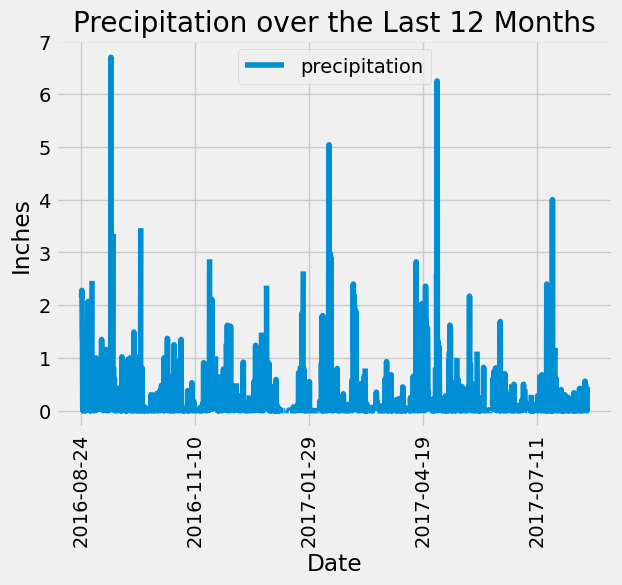

In [41]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
import datetime as dt
# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(most_recent_date[0], "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])
precipitation_df.set_index('date', inplace=True)


# Sort the dataframe by date
precipitation_df = precipitation_df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(rot=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation over the Last 12 Months')
plt.show()

In [42]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [43]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Station.station)).first()
station_count

(9,)

In [44]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [45]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

temperature_stats = session.query(
    func.min(Measurement.tobs), 
    func.max(Measurement.tobs), 
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station).first()
temperature_stats

(54.0, 85.0, 71.66378066378067)

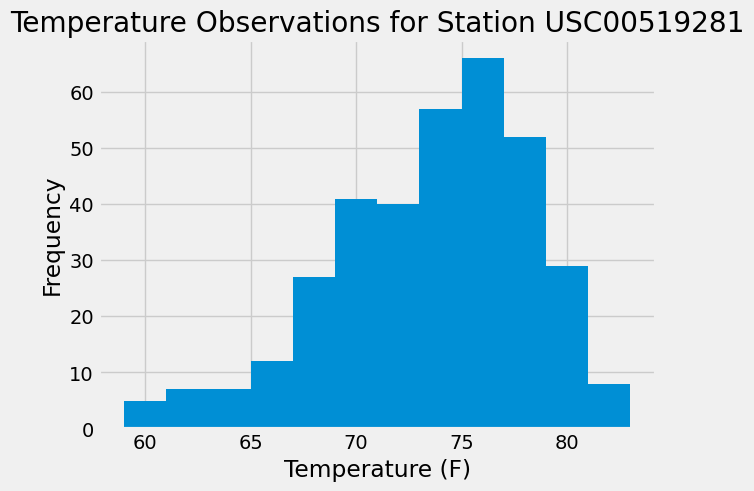

In [47]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()
# Convert the query results to a list
temperature_list = [temp[0] for temp in temperature_data]

# Plot the histogram
plt.hist(temperature_list, bins=12)
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station}')
plt.show()


# Close Session

In [48]:
# Query to find the earliest date in the dataset
earliest_date = session.query(func.min(Measurement.date)).first()
print(f"Earliest Date: {earliest_date[0]}")

# Query to find the most recent date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).first()
print(f"Most Recent Date: {most_recent_date[0]}")


Earliest Date: 2010-01-01
Most Recent Date: 2017-08-23


In [27]:
# Close Session
session.close()